In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from datetime import datetime
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
SEED = 265
torch.manual_seed(SEED)

DEVICE = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Using device: {DEVICE}")

torch.set_default_dtype(torch.double)

Using device: cuda


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(32 * 32 * 3, 512)
        self.h1 = nn.Linear(512, 128)
        self.h2 = nn.Linear(128, 32)
        self.output_layer = nn.Linear(32, 2)

    def forward(self, x):
        out = torch.flatten(x, 1)
        out = F.relu(self.input_layer(out))
        out = F.relu(self.h1(out))
        out = F.relu(self.h2(out))
        out = self.output_layer(out)
        return out

    def __str__(self) -> str:
        return "MyMLP"

In [40]:
def load_CIFAR2(train_val_split=.9, data_path='../data', preprocessor=None):
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.ToTensor(),
        ])

    data_train_val = datasets.CIFAR10(
        data_path,
        train=True,
        download=True,
        transform=preprocessor)
    
    data_test = datasets.CIFAR10(
        data_path,
        train=False,
        download=True,
        transform=preprocessor)

    n_train = int(len(data_train_val)*train_val_split)
    n_val = len(data_train_val) - n_train

    data_train, data_val = random_split(
        data_train_val,
        [n_train, n_val],
        generator=torch.Generator()
    )
    
    label_map = {0: 0, 2: 1}
    class_names = ['airplane', 'bird']
    
    data_train = [(img, label_map[label]) for img, label in data_train if label in [0, 2]]
    data_val = [(img, label_map[label]) for img, label in data_val if label in [0, 2]]
    data_test = [(img, label_map[label]) for img, label in data_test if label in [0, 2]]

    print("Size of training set: ", len(data_train))
    print("Size of validation set: ", len(data_val))
    print("Size of test set: ", len(data_test))

    return (data_train, data_val, data_test)

In [41]:
def train(n_epochs: int, optimizer: optim.Optimizer, model: nn.Module, loss_fn, train_loader: DataLoader):
    """
    Train a model with pytorch optimizer.
    """
    print(f"Training {model} with optimizer")
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []

    for epoch in range(1, n_epochs+1):
        model.train()
        loss_train = 0.0
            
        for imgs, labels in train_loader:
            imgs = imgs.to(device=DEVICE, dtype=torch.double)
            labels = labels.to(device=DEVICE)

            outputs = model(imgs)

            loss = loss_fn(outputs,labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print(f"{datetime.now().time()}, {epoch}, train_loss: {loss/n_batch:.5f}")

In [42]:
def train_manual_update(n_epochs: int, lr: float, model: nn.Module, loss_fn, train_loader: DataLoader, weight_decay=0, momentum=0):
    """
    Train a model with manual update to parameters.
    """
    print(f"Training {model} with manual update")
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []

    # Momentum buffer
    m_b = [torch.zeros_like(p) for p in model.parameters()] 
    for epoch in range(1, n_epochs+1):
        model.train()
        loss_train = 0.0

        for batch_n, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device=DEVICE, dtype=torch.double)
            labels = labels.to(device=DEVICE)

            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            loss.backward()

            with torch.no_grad():
                for i, p in enumerate(model.parameters()):
                    # L2 regularization
                    if weight_decay != 0:
                        p.grad = p.grad + weight_decay*p.data
                    # Momentum
                    if momentum != 0:
                        m_b[i] = (momentum*m_b[i]) + p.grad
                        p.grad = m_b[i]
                        
                    # Gradient step
                    new_params = p.data-lr*p.grad
                    p.copy_(new_params)
                
                        
                model.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print(f"{datetime.now().time()}, {epoch}, train_loss: {loss/n_batch:.5f}")


In [62]:
def evaluate(model: torch.nn, loader: DataLoader, calc_confusion_matrix: bool=False):
    model.eval()
    correct, total, cm, y_pred, y_true = 0, 0, None, list(), list()

    with torch.no_grad():
        # Load images and true labels from each batch
        for imgs, labels in loader:
            imgs = imgs.to(device=DEVICE)
            labels = labels.to(device=DEVICE)

            # Run predictions. Predicted label = prediction with highest confidence
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
        
            # Keep track of total and number of correct predictions
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    # Calculate accuracy
    acc = correct / total

    if calc_confusion_matrix: 
        # Calculate confusion matrix with Sklearn
        # positive = Airplane = 1, negative = Bird = 0
        cm = confusion_matrix(y_true, y_pred)
        return acc, cm
    else: 
        return acc

In [54]:
def compare_models(n_epochs: int, batch_size: int, train_loader: DataLoader, val_loader: DataLoader):
    """
    Trains and compares the two training functions.
    """
    loss_fn = nn.CrossEntropyLoss()
    seed = SEED

    print("\tGlobal parameters:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {n_epochs}")
    print(f"Loss function: {loss_fn}")
    print(f"Seed: {seed}")
    
    # train_loader = DataLoader(cifar_train, shuffle=False, batch_size=batch_size)
    # val_loader = DataLoader(cifar_val, shuffle=False, batch_size=batch_size)
    
    hyper_params = [
        {"lr": 0.01, "weight_decay": 0, "momentum": 0},
        {"lr": 0.01, "weight_decay": 0.01, "momentum": 0},
        {"lr": 0.01, "weight_decay": 0, "momentum": 0.01},
        {"lr": 0.01, "weight_decay": 0, "momentum": 0.9},
        {"lr": 0.01, "weight_decay": 0.01, "momentum": 0.9},
        {"lr": 0.001, "weight_decay": 0.01, "momentum": 0.9},
    ]

    models = []
    accuracies = []

    # Train both models with the different hyperparameters
    for hparam in hyper_params:
        print("\n", "="*50)
        print("\tCurrent parameters: ")
        [print(f"{key}:{value}") for key, value in hparam.items()]

        print("\n", "-"*6, "Using pytorch SGD", "-"*6)
        torch.manual_seed(SEED)
        model_auto = MyMLP()
        model_auto.to(device=DEVICE)
        optimizer = optim.SGD(model_auto.parameters(), **hparam)
        train(n_epochs, optimizer, model_auto, loss_fn, train_loader)
        train_acc_auto = evaluate(model_auto, val_loader)
        val_acc_auto, cm = evaluate(model_auto, train_loader, calc_confusion_matrix=True)
        models.append(model_auto)
        accuracies.append(val_acc_auto)
        
        print("\n", "-"*3, "Accuracies", "-"*3)
        print(train_acc_auto, val_acc_auto)
        print(f"Training accuracy: {round(train_acc_auto, 2)}")
        print(f"Validation accuracy: {round(val_acc_auto, 2)}")
        
        print("\n", "-"*6, "Using manual update", "-"*6)
        torch.manual_seed(SEED)
        model_manual = MyMLP()
        model_manual.to(device=DEVICE)
        train_manual_update(n_epochs, model=model_manual, train_loader=train_loader, loss_fn=loss_fn, **hparam)
        train_acc_manual = evaluate(model_manual, train_loader)
        val_acc_manual, cm2= evaluate(model_manual, val_loader, calc_confusion_matrix=True)
        
        models.append(model_manual)
        accuracies.append(val_acc_manual)
        
        print("\n", "-"*3, "Accuracies", "-"*3)
        print(f"Training accuracy: {round(train_acc_manual, 2)}")
        print(f"Validation accuracy: {round(val_acc_manual, 2)}")


    return models, accuracies, hyper_params

In [55]:
# Add normalization from training data
tensor_train, _, _ = load_CIFAR2()
imgs = torch.stack([img for img, _ in tensor_train])
print(imgs.shape)

normalizer = transforms.Normalize(
    imgs.mean(dim=(0,2,3)),
    imgs.std(dim=(0,2,3))
)

preprocessor = transforms.Compose([
    transforms.ToTensor(),
    normalizer
])

Files already downloaded and verified
Files already downloaded and verified
Size of training set:  8956
Size of validation set:  1044
Size of test set:  2000
torch.Size([8956, 3, 32, 32])


In [56]:
cifar_train, cifar_val, cifar_test = load_CIFAR2(preprocessor=preprocessor)

Files already downloaded and verified
Files already downloaded and verified
Size of training set:  8956
Size of validation set:  1044
Size of test set:  2000


In [57]:
n_epochs = 1
batch_size = 256
train_loader = DataLoader(cifar_train, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(cifar_val, shuffle=False, batch_size=batch_size)
models, accuracies, hyper_params = compare_models(n_epochs, batch_size, train_loader=train_loader, val_loader=val_loader)

	Global parameters:
Batch size: 256
Epochs: 1
Loss function: CrossEntropyLoss()
Seed: 265

	Current parameters: 
lr:0.01
weight_decay:0
momentum:0

 ------ Using pytorch SGD ------
Training MyMLP with optimizer
13:04:00.877979, 1, train_loss: 0.01915

 --- Accuracies ---
0.539272030651341 0.5850826261723984
Training accuracy: 0.54
Validation accuracy: 0.59

 ------ Using manual update ------
Training MyMLP with manual update
13:04:01.473945, 1, train_loss: 0.01915

 --- Accuracies ---
Training accuracy: 0.59
Validation accuracy: 0.54

	Current parameters: 
lr:0.01
weight_decay:0.01
momentum:0

 ------ Using pytorch SGD ------
Training MyMLP with optimizer
13:04:02.054725, 1, train_loss: 0.01916

 --- Accuracies ---
0.5335249042145593 0.583407771326485
Training accuracy: 0.53
Validation accuracy: 0.58

 ------ Using manual update ------
Training MyMLP with manual update
13:04:02.665294, 1, train_loss: 0.01916

 --- Accuracies ---
Training accuracy: 0.58
Validation accuracy: 0.53

	Curre

In [58]:
highest_acc = max(accuracies)
selected_idx = accuracies.index(highest_acc)
selected_model = models[selected_idx]

Used hyperparameters: {'lr': 0.01, 'weight_decay': 0, 'momentum': 0.9}
Accuracy of selected model: 0.78
Confusion matrix: [[794 206]
 [234 766]]


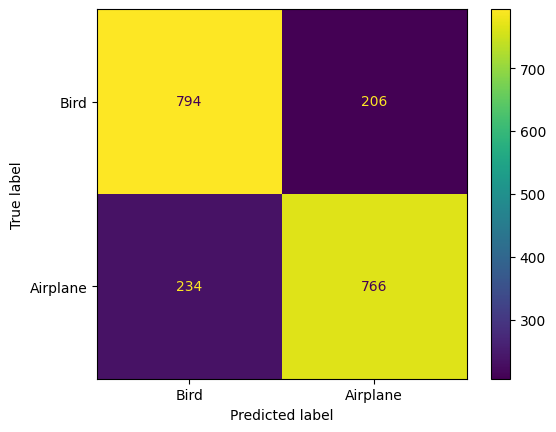

In [71]:
test_loader = DataLoader(cifar_test, shuffle=False, batch_size=batch_size)
acc, cm = evaluate(selected_model, test_loader, calc_confusion_matrix=True)
print(f"Used hyperparameters: {hyper_params[selected_idx//2]}")
print(f"Accuracy of selected model: {acc:.2f}")
print(f"Confusion matrix: {cm}")
# Visualize the confusion matrix. Positive = Airplane = 1, Negative = Bird = 0
disp = ConfusionMatrixDisplay(cm, display_labels=["Bird", "Airplane"])
disp.plot()
plt.show()